In [2]:
import cbpro
import numpy as np
import datetime
import pandas as pd
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy import stats
public_client = cbpro.PublicClient()

In [3]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,LeakyReLU
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random
pd.set_option('precision', 4)

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

## Extract data from API

In [4]:
def getData(label,start_time,end_time):
    '''pull out data from start date to end date'''
    #input
    #label -- string, type of currency, such as 'ETH-USD'
    #start_time, end_time -- ISO 8601 format date
    
    #output
    #numpy ndarray
    #pull out minute data
    data=public_client.get_product_historic_rates(label,start=start_time, end=end_time, granularity=300)
    return data

In [5]:
def getMinuteData(label, start_date, end_date):
    '''get all data of label from start_date to end_date'''
    sample = []
    date_list = pd.date_range(start=start_date, end=end_date)
    for head, tail in zip(date_list[:-1], date_list[1:]):
        tmp = getData(label,head.isoformat(),tail.isoformat())
        while len(tmp) == 1:
            time.sleep(0.8)
            tmp = getData(label,head.isoformat(),tail.isoformat())
        sample += tmp
        time.sleep(0.5)
    return sample

In [6]:
def save_data(data,tag):
    '''save the data in dictionary into separated csv file'''
    
    #transform to pandas dataframe format and add columne name
    result=pd.DataFrame(data,columns=['date','low','high','open','close','volume'])
    
    #transform unix time to datetime for better understand
    result['date']=pd.to_datetime(result['date'], unit='s')
    filename=tag+'_2017.csv'
    result.to_csv(filename)
    #return result    

In [7]:
# #extract from API and save into excel file
# #Extract 2017 data

# start_date, end_date = '08/15/2017', '08/15/2018'
# ticker = ticker=['BTC-USD','ETH-USD','LTC-USD']
# for tick in ticker:
#     data = getMinuteData(tick, start_date, end_date)
#     save_data(data, tick)

## Read Data from CSV file

In [5]:
def extract_merge(year):
    """extract data from csv file and merge them into 1 table"""
    tick = ['BTC', 'ETH', 'LTC']
    if year == '2018':
        ticker = ["Data/" + i + '-USD.csv' for i in tick]
    else:
        ticker = ["Data/" + i + '-USD_2017.csv' for i in tick]
    BTC_data = pd.read_csv(ticker[0],parse_dates=['date'])
    BTC_data=BTC_data.drop(BTC_data.columns[0],axis=1)
    ETH_data=pd.read_csv(ticker[1],parse_dates=['date'])
    ETH_data=ETH_data.drop(ETH_data.columns[0],axis=1)
    LTC_data=pd.read_csv(ticker[2],parse_dates=['date'])
    LTC_data=LTC_data.drop(LTC_data.columns[0],axis=1)
    
    #merge BTC & ETH data
    merge1=BTC_data.merge(ETH_data, how='inner', on='date', suffixes=('_BTC','_ETH'))
    #merge above table with LTC data
    merge2=pd.merge(merge1,LTC_data,how='inner', on='date')
    #change the colume name
    merge2=merge2.rename(columns={i:i+'_LTC' for i in list(LTC_data)[1:]})
    merge2 = merge2.drop_duplicates()
    
    return merge2

In [6]:
merge2 = extract_merge('2018')
merge2_2017 = extract_merge('2017')

In [10]:
# #read the data from csv file
# BTC_data=pd.read_csv('BTC-USD.csv',parse_dates=['date'])
# BTC_data=BTC_data.drop(BTC_data.columns[0],axis=1)
# ETH_data=pd.read_csv('ETH-USD.csv',parse_dates=['date'])
# ETH_data=ETH_data.drop(ETH_data.columns[0],axis=1)
# LTC_data=pd.read_csv('LTC-USD.csv',parse_dates=['date'])
# LTC_data=LTC_data.drop(LTC_data.columns[0],axis=1)

# '''
# align all data sets
# '''

# #merge BTC & ETH data
# merge1=BTC_data.merge(ETH_data, how='inner', on='date', suffixes=('_BTC','_ETH'))
# #merge above table with LTC data
# merge2=pd.merge(merge1,LTC_data,how='inner', on='date')
# #change the colume name
# merge2=merge2.rename(columns={i:i+'_LTC' for i in list(LTC_data)[1:]})
# merge2 = merge2.drop_duplicates()

## Start RNN model

### generate log return (here use percentage return)

In [11]:
#change all price into log return
def convert_log_return(data):
    '''change price into percentage log return'''
    length = len(list(data))
    sample_data = data
    for col_name in list(sample_data)[1:]:
        new_col_name = 'return_' + col_name
        #calculate percentage change
        tmp =sample_data[col_name].pct_change()
        
        #convert percentage return into log
        #if return == 0, log return == 0
        tmp = tmp.map(lambda x: (np.log(x) if x > 0 else -np.log(-x)))
        tmp = tmp.map(lambda x: (0 if x == float('inf') else x))
        sample_data[new_col_name] = tmp
    
    #return the return matrix
    return_matrix = sample_data.filter(like='return')
    return sample_data.filter(like='return')

In [25]:
# #change all price into percentage return
#not take log here


# def convert_log_return(data):
#     '''change price into percentage log return'''
#     length = len(list(data))
#     sample_data = data
#     for col_name in list(sample_data)[1:]:
#         new_col_name = 'return_' + col_name
#         #calculate percentage change
#         tmp =sample_data[col_name].pct_change()
        
# #         #convert percentage return into log
# #         #if return == 0, log return == 0
# #         tmp = tmp.map(lambda x: (np.log(x) if x > 0 else -np.log(-x)))
# #         tmp = tmp.map(lambda x: (0 if x == float('inf') else x))
#         sample_data[new_col_name] = tmp
    
#     #return the return matrix
#     return_matrix = sample_data.filter(like='return')
#     return sample_data.filter(like='return')

In [12]:
def create_dataset(data, time_step, tick1, tick2, target):
    '''convert time series data into X, y'''
    """given tag name(tick1, tick2) of two crpytocurrency"""
    """X = [low1, high1, open1, close1, volume1, low2, high2, open2, close2, volume2] for time (i, i + timestep)"""
    
    #use #timestep data from tick1, tick2 to predict next time stamp tick1' open price
    
    #create colume label
    input_label1 = ['return_' + i + '_' + tick1 for i in ['low', 'high', 'open','close', 'volume']]
    input_label2 = ['return_' + i + '_' + tick2 for i in ['low', 'high', 'open','close', 'volume']]
    
    target_label = 'return_open_' + target
    
    tmp_data1 = data[input_label1]
    tmp_data2 = data[input_label2]
    tmp_target = data[target_label]
    
    transformed_X = []
    transformed_y = []
    for i in range(time_step, data.shape[0]):
        tmp1 = tmp_data1[(i - time_step): i].values.tolist()
        tmp2 = tmp_data2[(i - time_step): i].values.tolist()
        tmp = []
        for j in range(len(tmp1)):
            tmp.append(tmp1[j] + tmp2[j])
            
        #tmp = [low1, high1, open1, close1, volume1, low2, high2, open2, close2, volume2]
        transformed_X.append(tmp)
        transformed_y.append(tmp_target.iloc[i])
    
    return np.asarray(transformed_X), np.asarray(transformed_y)

### train, test, validation split by week

In [13]:
def generate_week_list(start_date, end_date):
    '''generate the start and end day of each week'''
    '''week_list = {1: [start, end]}'''
    """In order to split train, test, validation in future step"""
    week_list = {}
    curr_week = start_date
    i = 1
    while curr_week < end_date:
        end_week = curr_week + datetime.timedelta(days = 7)
        week_list[i] = [curr_week, end_week]
        curr_week, i = end_week, i + 1
    
    return week_list

In [14]:
def extract_sample(index, week_list, date, X, y):
    '''given index of week we want to sample, extract corresponding sample'''
    
    sample_X, sample_y = [], []
    for i in index:
        start, end = week_list[i]
        tmp_index = [(date < end) & (date >= start)]
        try:
            sample_X = np.concatenate((sample_X, X[tmp_index]), axis = 0)
            sample_y = np.concatenate((sample_y, y[tmp_index]), axis = 0)
        except:
            sample_X = X[tmp_index]
            sample_y = y[tmp_index]
    
    return sample_X, sample_y

In [15]:
def train_test_val(X, y, date):
    '''split train, test, validation'''
    #-----------------------------------------#
    #--e.g. 52 weeks in total, 0.8, 0.1, 0.1--#
    #-----------------------------------------#
    
    start, end = date.iloc[0], date.iloc[-1]
    week_list = generate_week_list(start, end)
    index = list(week_list.keys())
    train_index, test_index = train_test_split(index, test_size = 0.2)
    test_index, val_index = train_test_split(test_index, test_size = 0.5)
    train_X, train_y = extract_sample(train_index, week_list, date, X, y)
    test_X, test_y = extract_sample(test_index, week_list, date, X, y)
    val_X, val_y = extract_sample(val_index, week_list, date, X, y)
    
    return train_X, train_y, test_X, test_y, val_X, val_y

### RNN main program

In [23]:
def step_decay(epoch):
    """learning rate scheduler"""
    """start from initial_rate, after epochs_drop step, drop"""
    initial_rate = 0.1
    drop = 0.1
    epochs_drop = 1.0
    
    lrate = initial_rate * math.pow(drop, math.floor((1 + epoch)/epochs_drop))
    
    return lrate
                                    

In [17]:
def train_RNN(train_X, train_y, test_X, test_y, val_X, val_y, drop_rate, hidden_unit):
    '''RNN'''
    
    #------------LSTM-------------------------

    n_step, n_feature = train_X.shape[1:]
    model = Sequential()

    # Embedding layer
    model.add(LSTM(hidden_unit, input_shape=(n_step, n_feature), activation='tanh', return_sequences=False))
#     model.add(LSTM(hidden_unit, input_shape=(n_step, n_feature), return_sequences=False))
#     model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(drop_rate))

    model.add(Dense(16, activation='tanh'))
#     model.add(Dense(16))
#     model.add(LeakyReLU(alpha=0.3))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    lrate = LearningRateScheduler(step_decay)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
    history = model.fit(train_X, train_y, epochs=100, batch_size = 100, verbose=1, validation_data=(val_X, val_y), callbacks = [es, lrate])

    testPredict = model.predict(test_X)
    #score = model.evaluate(y_test, testPredict)
    
    return history, testPredict



In [29]:
#merge2 is the extract & merge data
#return matrix stores all log percentage return data
return_matrix = convert_log_return(merge2)
#add date colume for splitting
return_matrix['date'] = merge2['date']
#first row is NA, so drop it
return_matrix = return_matrix.drop(0, axis = 0)

In [31]:
data = return_matrix
time_step = 60 # about 5 hours
tick1, tick2 = 'BTC', 'ETH'
target = 'BTC'
#X is N x time_step x 10 matrix
X, y = create_dataset(data, time_step, tick1, tick2, target)

In [32]:
date = return_matrix['date'][time_step:]
train_X, train_y, test_X, test_y, val_X, val_y = train_test_val(X, y, date)

In [33]:
train_X.shape

(82518, 60, 10)

In [34]:
test_X.shape

(10080, 60, 10)

In [36]:
# drop_rate_range = [0.1, 0.2, 0.3, 0.4]
# hidden_unirt_range = [32, 64, 128, 256]

In [36]:
#if not take log for percentage return
history, testPredict = train_RNN(train_X, train_y, test_X, test_y, val_X, val_y, 0.4, 64)

Train on 82518 samples, validate on 12030 samples
Epoch 1/100
82518/82518 [==============================] - 35s 424us/step - loss: 4.7510e-04 - mean_absolute_error: 0.0052 - val_loss: 6.4542e-06 - val_mean_absolute_error: 0.0012
Epoch 2/100
82518/82518 [==============================] - 35s 425us/step - loss: 1.7533e-05 - mean_absolute_error: 0.0016 - val_loss: 6.0534e-06 - val_mean_absolute_error: 0.0011
Epoch 3/100
82518/82518 [==============================] - 35s 429us/step - loss: 1.7301e-05 - mean_absolute_error: 0.0015 - val_loss: 5.7038e-06 - val_mean_absolute_error: 9.9340e-04
Epoch 4/100
82518/82518 [==============================] - 36s 437us/step - loss: 1.7230e-05 - mean_absolute_error: 0.0015 - val_loss: 5.7000e-06 - val_mean_absolute_error: 9.9608e-04
Epoch 5/100
82518/82518 [==============================] - 36s 433us/step - loss: 1.7225e-05 - mean_absolute_error: 0.0015 - val_loss: 5.6958e-06 - val_mean_absolute_error: 9.9166e-04
Epoch 6/100
82518/82518 [=============

In [43]:
#using relu as activation function
#if take log percentage return
history, testPredict = train_RNN(train_X, train_y, test_X, test_y, val_X, val_y, 0.4, 64)

Train on 82492 samples, validate on 12094 samples
Epoch 1/100
82492/82492 [==============================] - 35s 427us/step - loss: 58.0065 - mean_absolute_error: 7.2200 - val_loss: 64.3941 - val_mean_absolute_error: 7.4910
Epoch 2/100
82492/82492 [==============================] - 36s 440us/step - loss: 57.7621 - mean_absolute_error: 7.2066 - val_loss: 64.3471 - val_mean_absolute_error: 7.4904
Epoch 3/100
82492/82492 [==============================] - 39s 469us/step - loss: 57.7210 - mean_absolute_error: 7.2031 - val_loss: 64.3444 - val_mean_absolute_error: 7.4903
Epoch 4/100
82492/82492 [==============================] - 39s 475us/step - loss: 57.7033 - mean_absolute_error: 7.2024 - val_loss: 64.3441 - val_mean_absolute_error: 7.4903
Epoch 5/100
82492/82492 [==============================] - 40s 483us/step - loss: 57.7075 - mean_absolute_error: 7.2022 - val_loss: 64.3440 - val_mean_absolute_error: 7.4903
Epoch 6/100
82492/82492 [==============================] - 38s 466us/step - loss

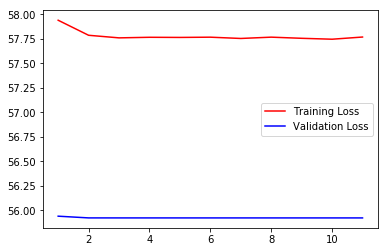

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(1, len(loss) + 1), loss, 'r-', label='Training Loss')
plt.plot(range(1, len(loss) + 1), val_loss, 'b-', label='Validation Loss')
plt.legend()
plt.show()

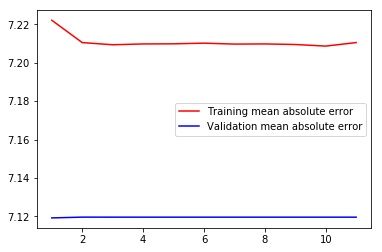

In [25]:
val_mae = history.history['val_mean_absolute_error']
mae= history.history['mean_absolute_error']
plt.plot(range(1, len(loss) + 1), mae, 'r-', label='Training mean absolute error')
plt.plot(range(1, len(loss) + 1), val_mae, 'b-', label='Validation mean absolute error')
plt.legend()
plt.show()

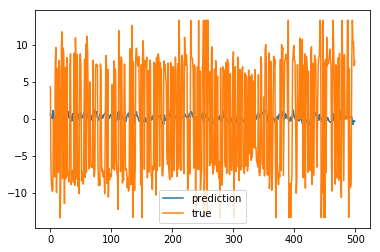

In [26]:
plt.plot(testPredict[:500])
plt.plot(test_y[:500])
plt.legend(['prediction','true'])

## Baseline: ARIMA

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA 

In [54]:
result = adfuller(test_y)

In [55]:
print("The p-value is: ", result[1])

The p-value is:  0.0


In [56]:
#find the order of ARIMA
min_p = min_q = float('inf')
min_bic = float('inf')
for p in range(1,8):
    for q in range(1,8):
        try:
            tmp_bic=ARIMA(test_y, (p, 0, q)).fit().bic
            if tmp_bic<min_bic:
                min_p,min_q=p,q
                min_bic=tmp_bic
        except:
            continue

In [34]:
model = ARIMA(test_y, (4, 0, 4)).fit()

In [35]:
pred_y = model.predict()

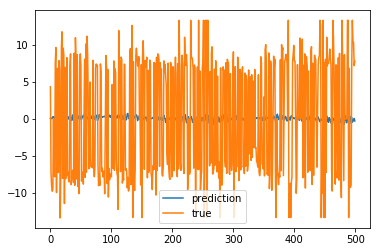

In [40]:
plt.plot(pred_y[:500])
plt.plot(test_y[:500])
plt.legend(['prediction','true'])

In [37]:
#model = ARIMA(train_data, (1, 0, 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                10078
Model:                     ARMA(4, 4)   Log Likelihood              -35083.272
Method:                       css-mle   S.D. of innovations              7.864
Date:                Wed, 04 Sep 2019   AIC                          70186.545
Time:                        19:36:51   BIC                          70258.726
Sample:                             0   HQIC                         70210.968
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0756      0.069      1.096      0.273      -0.060       0.211
ar.L1.y        0.5863      0.123      4.785      0.000       0.346       0.826
ar.L2.y       -0.0440      0.129     -0.341      0.733      -0.297       0.209
ar.L3.y       -0.4287      0.133     -3.230      0.001      -0.689      -0.169
ar.L4.y        0.8143      0.102      7.949      0.000       0.614       1.015
ma.L1.y       -0.5882      0.127     -4.628      0.000      -0.837      -0.339
ma.L2.y        0.0378      0.133      0.284      0.776      -0.223       0.299
ma.L3.y        0.4174      0.138      3.028      0.002       0.147       0.687
ma.L4.y       -0.8034      0.106     -7.595      0.000      -1.011      -0.596
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0873           -0.0000j            1.0873           -0.5000
AR.2            0.2929           -1.0064j            1.0481           -0.2049
AR.3            0.2929           +1.0064j            1.0481            0.2049
AR.4            1.0281           -0.0000j            1.0281           -0.0000
MA.1           -1.0923           -0.0000j            1.0923           -0.5000
MA.2            0.2935           -1.0128j            1.0545           -0.2051
MA.3            0.2935           +1.0128j            1.0545            0.2051
MA.4            1.0248           -0.0000j            1.0248           -0.0000
-----------------------------------------------------------------------------
"""